# Loading Packages

In [1]:
import os
import torch
from utils.visualize       import visualize_images_from_classes
from utils.datasets        import returnDataLoader
from utils.model_execution import runFMA, runDLA
from utils.analysis        import print_analysis

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.xpu.is_available():
    device = torch.device("xpu")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: xpu


# Load Patches

In [3]:
while True:
    data_dir = input(r"Please enter the dataset directory, for example: ./data/: ") or "./data/"
    if not os.path.isdir(data_dir):
        print(f"Directory '{data_dir}' does not exist. Please try again.\n")
        continue
    print("\nDataset directory confirmed.\n")
    break

classes = []

while True:
    class_name = input(r"Please enter class names, seperated by enter, for example: blur or artifact_free (or press enter to finish): ").strip()
    if class_name == "":
        break
    class_path = os.path.join(data_dir, class_name)
    if os.path.isdir(class_path):
        classes.append(class_name)
        print(f"Class folder '{class_path}' exists and was added. Please add another or press enter to continue.")
    else:
        print(f"Class folder '{class_path}' does not exist. Please check name.")

if classes:
    print("\nDataset loaded successfully.")
else:
    print("\nNo valid class folders were provided. Defaulting to sample classes.")
    classes = ['artifact_free', 'blur']



Dataset directory confirmed.


No valid class folders were provided. Defaulting to sample classes.


# Random visualization of different classes

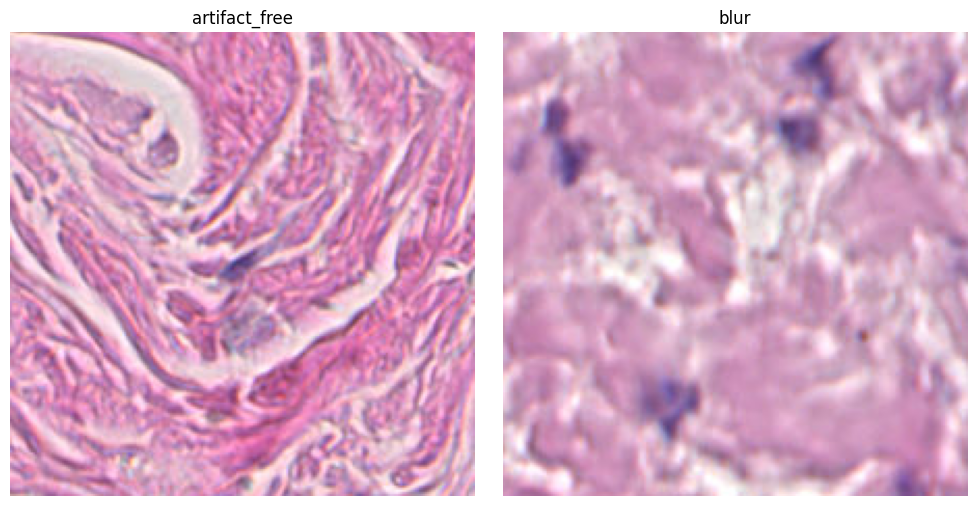

In [4]:
visualize_images_from_classes(data_dir, classes)

# Prepare data for classification

In [5]:
dataloader = returnDataLoader(data_dir, classes)
print("Total dataset size (samples): ", len(dataloader.dataset))


Total dataset size (samples):  2


# Classify images with different models

### FMA

In [ ]:
runFMA(dataloader, device, './models/uni_binary.pth')

Epoch 1 [test]: 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


### DLA

In [7]:
runDLA(dataloader, device, './models/resnet_binary.pth')

/home/sysop/programming/python/HistoART/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sysop/programming/python/HistoART/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1 [test]: 100%|██████████| 1/1 [00:00<00:00,  1.91it/s]


### KBA

# Analysis

####################
Results for My Results
          pred:yes  pred:no
true:yes     99996       10
true:no     122376      113
Precision:  0.4496789164103394
Precision_CI:  (np.float64(0.44761131233914836), np.float64(0.45174652048153047))
Recall:  0.99990000599964
Recall_CI:  (np.float64(0.9998380333136374), np.float64(0.9999619786856426))
Delong Method
AUC: 0.8446726716549837
AUC COV: 7.280791002428966e-07
95% AUC CI: [0.84300028 0.84634506]
Original ROC area: 0.845
Bootstrap #1 ROC area: 0.845
Bootstrap #2 ROC area: 0.844
Bootstrap #3 ROC area: 0.845
Bootstrap #4 ROC area: 0.843
Bootstrap #5 ROC area: 0.845
Bootstrap #6 ROC area: 0.845
Bootstrap #7 ROC area: 0.846
Bootstrap #8 ROC area: 0.845
Bootstrap #9 ROC area: 0.845
Bootstrap #10 ROC area: 0.846
Bootstrap #11 ROC area: 0.845
Bootstrap #12 ROC area: 0.845
Bootstrap #13 ROC area: 0.846
Bootstrap #14 ROC area: 0.845
Bootstrap #15 ROC area: 0.844
Bootstrap #16 ROC area: 0.846
Bootstrap #17 ROC area: 0.845
Bootstrap #18 ROC area: 0

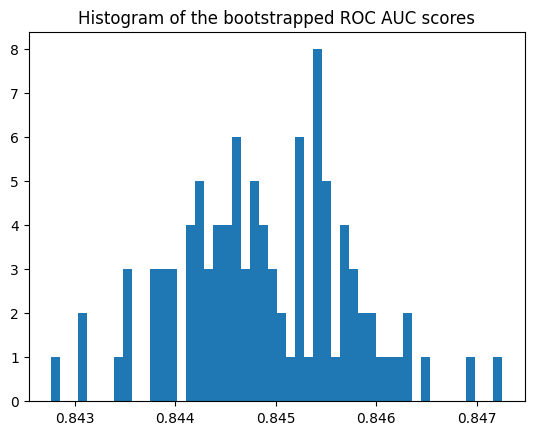

Bootstrap
Confidence interval for the score: [0.844 - 0.846]


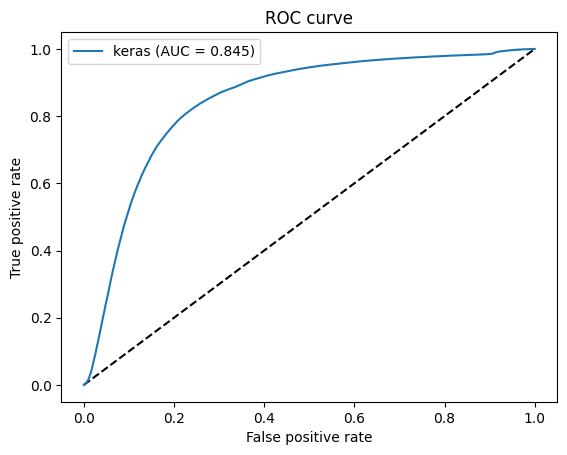

(0.4496789164103394, (np.float64(0.44761131233914836), np.float64(0.45174652048153047)), 0.99990000599964, (np.float64(0.9998380333136374), np.float64(0.9999619786856426)), np.float64(0.8446726716549837), np.float64(7.280791002428966e-07), array([0.84300028, 0.84634506]), array([0.00000000e+00, 0.00000000e+00, 8.16399840e-06, ...,
       9.99975508e-01, 9.99975508e-01, 1.00000000e+00], shape=(18573,)), array([0.00000000e+00, 9.99940004e-06, 9.99940004e-06, ...,
       9.99980001e-01, 1.00000000e+00, 1.00000000e+00], shape=(18573,)), np.float64(0.8446726716549838),           pred:yes  pred:no
true:yes     99996       10
true:no     122376      113)
####################
Results for My Results
          pred:yes  pred:no
true:yes     99904      102
true:no     121750      739
Precision:  0.45072049229880806
Precision_CI:  (np.float64(0.44864910811939995), np.float64(0.45279187647821617))
Recall:  0.9989800611963282
Recall_CI:  (np.float64(0.998782227379441), np.float64(0.9991778950132154)

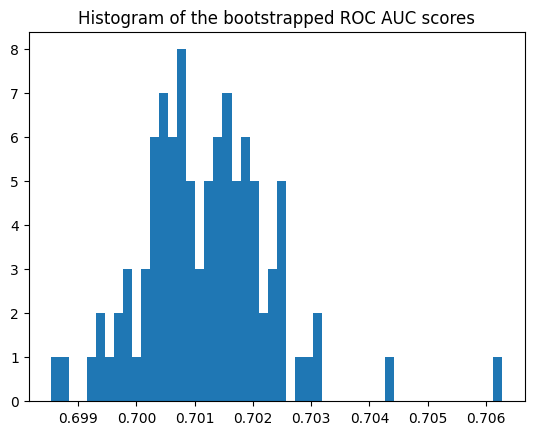

Bootstrap
Confidence interval for the score: [0.700 - 0.703]


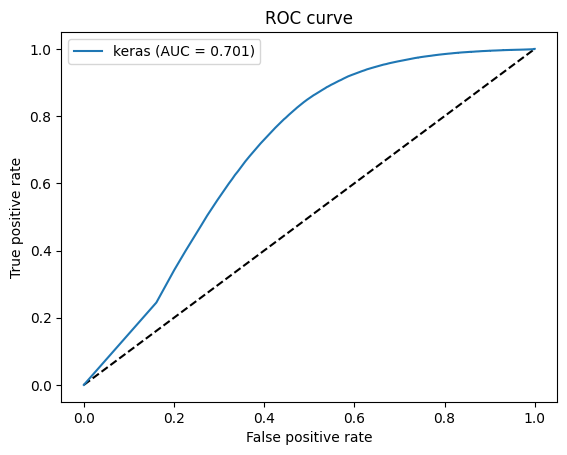

(0.45072049229880806, (np.float64(0.44864910811939995), np.float64(0.45279187647821617)), 0.9989800611963282, (np.float64(0.998782227379441), np.float64(0.9991778950132154)), np.float64(0.7010112668880946), np.float64(1.1961124562224793e-06), array([0.69886771, 0.70315482]), array([0.        , 0.16090424, 0.20068741, ..., 0.99999184, 1.        ,
       1.        ], shape=(10339,)), array([0.        , 0.24520529, 0.34234946, ..., 0.99984001, 0.99984001,
       1.        ], shape=(10339,)), np.float64(0.7010112668880945),           pred:yes  pred:no
true:yes     99904      102
true:no     121750      739)
####################
Results for My Results
          pred:yes  pred:no
true:yes     99904      102
true:no     121750      739
Precision:  0.45072049229880806
Precision_CI:  (np.float64(0.44864910811939995), np.float64(0.45279187647821617))
Recall:  0.9989800611963282
Recall_CI:  (np.float64(0.998782227379441), np.float64(0.9991778950132154))
Delong Method
AUC: 0.7010112668880946
AUC C

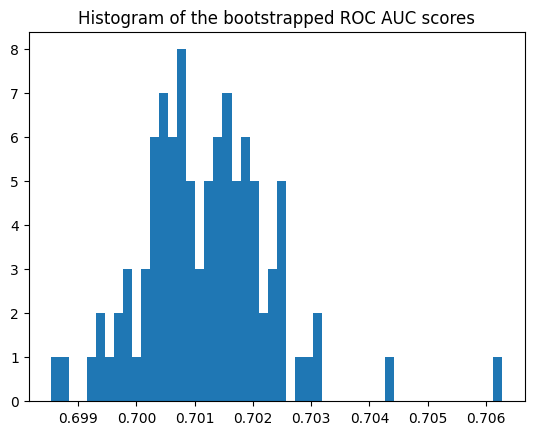

Bootstrap
Confidence interval for the score: [0.700 - 0.703]


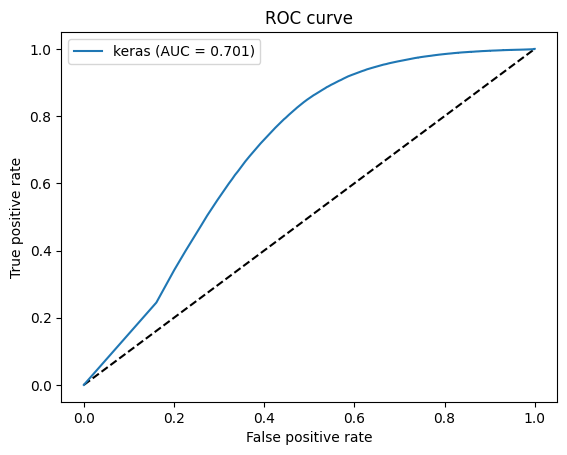

(0.45072049229880806, (np.float64(0.44864910811939995), np.float64(0.45279187647821617)), 0.9989800611963282, (np.float64(0.998782227379441), np.float64(0.9991778950132154)), np.float64(0.7010112668880946), np.float64(1.1961124562224793e-06), array([0.69886771, 0.70315482]), array([0.        , 0.16090424, 0.20068741, ..., 0.99999184, 1.        ,
       1.        ], shape=(10339,)), array([0.        , 0.24520529, 0.34234946, ..., 0.99984001, 0.99984001,
       1.        ], shape=(10339,)), np.float64(0.7010112668880945),           pred:yes  pred:no
true:yes     99904      102
true:no     121750      739)


In [11]:
print_analysis('./results/fma_binary_external.csv')
print_analysis('./results/dla_binary_external.csv')
print_analysis('./results/dla_binary_external.csv')